# Final Project

### Student: Jan Carbonell

### Lab Objective:
The Objective of this project are the following: 


In [1]:
# Import comet_ml in the top of the file for experiment tracking
from comet_ml import Experiment

experiment = Experiment(api_key="WgXEAqBycAS6nrjJC5zkNTLA2",
                        project_name="general", workspace="jcllobet")


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jcllobet/general/9537dfd4d60041b593fb21e6c50546c6



In [2]:
#intial set of imports
import nltk

from nltk.corpus import wordnet, stopwords, treebank, wordnet_ic
from nltk.metrics import jaccard_distance, edit_distance
from nltk import pos_tag
from nltk.parse import CoreNLPParser
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tag import PerceptronTagger
from nltk.wsd import lesk


tagger = CoreNLPParser(url='http://localhost:9000', tagtype='ner')

import pandas as pd
import string
import regex

random_state = 42

#variable initialization and instantiation
tests = []
tests_lem = []
gold_std_train = []
gold_std_test = []
lem1 = []
lem2 = []


## 1. Read all pairs of sentences of the train and test set
We proceed to open and read the input file

In [3]:
def text_to_sentences(filename):
    sentence_pair_array = []
    for line in open(filename, encoding="UTF8").readlines():
        sentence_pair_array.append([s.strip() for s in line.split("\t")])
    return sentence_pair_array

# TRIAL TESTING
trial_input = text_to_sentences('./00_data/trial/STS.input_fixed.txt')
trial_classes = open('./00_data/trial/STS_fixed.gs.txt', encoding="utf-8-sig").readlines()

# TRAINING PHASE
train_input = text_to_sentences('./00_data/train/STS.input.MSRpar_vid_SMT.txt')
train_classes = open('./00_data/train/STS.gs.MSRpar_vid_SMT.txt', encoding="utf-8-sig").readlines()

# TESTING PHASE
test_input = text_to_sentences('./00_data/test-gold/STS.input.ALL.txt')
test_classes = open('./00_data/test-gold/STS.gs.ALL.txt', encoding="UTF8").readlines()

We implement the lematizer. 

## 2. Noisy entities removal functions
### Stopwords, URL's, Punctuations

In [4]:
# Removing the punctuation and lowering the case of a string
def preprocessing(line):
    
    line = line.lower() 
    
    # Clean the text
    line = regex.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", line)
    line = regex.sub(r"what's", "what is ", line)
    line = regex.sub(r"\'s", " ", line)
    line = regex.sub(r"\'ve", " have ", line)
    line = regex.sub(r"can't", "cannot ", line)
    line = regex.sub(r"n't", " not ", line)
    line = regex.sub(r"i'm", "i am ", line)
    line = regex.sub(r"\'re", " are ", line)
    line = regex.sub(r"\'d", " would ", line)
    line = regex.sub(r"\'ll", " will ", line)
    line = regex.sub(r",", " ", line) # changed to ", " instead of ","
    line = regex.sub(r"\.", " ", line)
    line = regex.sub(r"<", " ", line)
    line = regex.sub(r">", " ", line)
    line = regex.sub(r"!", " ! ", line)
    line = regex.sub(r"\/", " ", line)
    line = regex.sub(r"\^", " ^ ", line)
    line = regex.sub(r"\+", " + ", line)
    line = regex.sub(r"\-", " - ", line)
    line = regex.sub(r"\=", " = ", line)
    line = regex.sub(r"'", " ", line) #careful, it used to be " ". Testing again for accuracy purposes. 
    line = regex.sub(r"(\d+)(k)", r"\g<1>000", line)
    line = regex.sub(r":", " : ", line)
    line = regex.sub(r" e g ", " eg ", line)
    line = regex.sub(r" b g ", " bg ", line)
    line = regex.sub(r" u s ", " american ", line)
    line = regex.sub(r"\0s", "0", line)
    line = regex.sub(r" 9 11 ", "911", line)
    line = regex.sub(r"e - mail", "email", line)
    line = regex.sub(r"j k", "jk", line)
    line = regex.sub(r"\s{2,}", " ", line)

    #only accept alphanum
    # [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    #remove punctuation
    return line.translate(str.maketrans('', '', string.punctuation))

## 3. Word normalization
### Tokenization, Lemmatization and stemming

In [5]:
#initializing stemmer & perceptron POS TAGGER
stemmer = PorterStemmer()
#PERCEPTRON POS TAGGER
pos_model = PerceptronTagger(load=False)
pos_model.train(treebank.tagged_sents())

#testing that it works
print(stemmer.stem("running"))
print(stemmer.stem("a"))

run
a


In [6]:
# extract the words from the sentence minus stopwords

def words_from_sent(sent):
    # tokenized
    tokenized = nltk.word_tokenize(sent)
    # remove stopwords and return
    return [word for word in tokenized if word not in nltk.corpus.stopwords.words('english')]

def stopwords_from_sent(sent):
    # tokenized
    tokenized = nltk.word_tokenize(sent)
    # remove stopwords and return
    return [word for word in tokenized if word in nltk.corpus.stopwords.words('english')]
    
# convert words to tokens
def wordnet_pos_tag_from_words(words):
    return pos_tag(words)

# convert words to tokens
def treebank_pos_tag_from_words(words):
    return pos_model.tag(words)

# Function to get wordnet pos code
def wordnet_pos_code(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None    

# Tokens to lemmas using wordnet lemmatizer    
def tokens_to_lemmas(tokens):
    return list(map(pos_tag_to_lemmas, tokens))

def pos_tag_to_lemmas(token):    
    pos = wordnet_pos_code(token[1])
    if pos:
        return WordNetLemmatizer().lemmatize(token[0], pos=pos)
    return token[0]

def tokens_to_stemming(tokens):
    return list(stemmer.stem(token) for token in tokens)
    #print(tokens_to_stemms(['a','running','verbose','singing']))

## 4. Synset, Nammed Entity and Content Parsing


In [7]:
def lesking_sentence(pos_tagged_sentence):
    """
    Returns a sentence as the given sentece using lesker algorithms.
    The input sentence must be a pos_tagged sentence (e.g. [('The', 'DN'),
    ('sun', 'NN')]).
    """
    sentence = [i[0] for i in pos_tagged_sentence]
    result = []
    
    none_type_objects = []
    for word, tag in pos_tagged_sentence:
        # 'NoneType' object has no attribute 'name'
        try:
            result.append(lesk(sentence,word, wordnet_pos_code(tag)).name())
        except:
            result.append(word)            
    return result

def get_stanford_named_entity_chunked(sentence):
    """Given the passed a tokenized sentence, returns an array with the chunks (words and named entities) it contains, using Stanford NLP"""
    
    tokenized_s = nltk.word_tokenize(sentence)
    
    # tag and run as a normal word or a named entity (e.g. a person or an organization)
    tagged_s = tagger.tag(tokenized_s)
    #print(tagged_s)
    
    chunked_sentence = []
    last_token = ''
    last_tag = ''
    
    for tagged_token in tagged_s:
        
        token = tagged_token[0]
        tag = tagged_token[1]
        
        # make normal words have lower case, also discard punctuation marks
        if tag == 'O':
            if token.isalnum():
                chunked_sentence.append(token.lower())
         
        # keep named entities with the original capitalization
        else:
            if last_tag == tag:
                chunked_sentence[-1] += ' ' + token
            else:
                chunked_sentence.append(token)
        
        last_token = token
        last_tag = tag
    
    return chunked_sentence

# example: note it does not group the terms of named entities, always 1 by 1. 
#print(get_stanford_named_entity_chunked("Mark Pedersen and John Smith are working at Google since 1994 for 1000$ per week."))

## 6. Distances, similarity and evaluation

In [8]:
# evaluation imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import re, math
from collections import Counter
%matplotlib inline

#jaccard and edit distances
def jaccard_d(list_0, list_1):
    if len(set(list_0)) == 0 or len(set(list_1)) == 0:
        return len(set(list_0).union(set(list_1)))
    else:
        return float(jaccard_distance(set(list_0),set(list_1)))
    
def edit_d(list_0, list_1):
    return float(edit_distance(list_0,list_1))

def jaro_winkler(s1, s2):
    try:
        return jaro_winkler_similarity(set(s1), set(s2))
    except:
        return (len(s1)+len(s2))


def cosine_similarity(sent1, sent2): #
    """
    Calculates cosine between 2 sentences/documents.
    Implementation of the formula described in lab 2, improving from Stack Overflow: http://goo.gl/ykibJY
    """
    WORD = re.compile(r'\w+')
    def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)

    vector1 = text_to_vector(sent1)
    vector2 = text_to_vector(sent2)
    cosine = get_cosine(vector1, vector2)
    return cosine

#Average character count
def get_difference_avg_char_count(token_0, token_1):
    sum_0 = 0
    sum_1 = 0
    for t in token_0:
        sum_0 = sum_0 + len(t)
    for k in token_1:
        sum_1 = sum_1 + len(k)
    
    return (sum_0- sum_1)

def is_partial_lemma_set_match(lemmas_0, lemmas_1):
    # Calculate Jaccard similarity
    ratio = len(set(lemmas_0).intersection(lemmas_1)) / float(len(set(lemmas_0).union(lemmas_1)))
    return (ratio > 0.66)

def is_partial_ner_set_match(ner_0, ner_1):
    # Calculate Jaccard similarity
    ratio = len(set(ner_0).intersection(ner_1)) / float(len(set(ner_0).union(ner_1)))
    return (ratio > 0.66)
    

## Main Program

In [9]:
def main_feature_generation(sent_0, sent_1):
    #print('.', end='')
    
    prosent_0, prosent_1 = preprocessing(sent_0), preprocessing(sent_1)

    stop_0, stop_1 = stopwords_from_sent(prosent_0), stopwords_from_sent(prosent_1)
    token_0, token_1 = words_from_sent(prosent_0), words_from_sent(prosent_1)
    #ner_0, ner_1 = get_stanford_named_entity_chunked(sent_0), get_stanford_named_entity_chunked(sent_1)
    #ner_ratio_jaccard = is_partial_ner_set_match(ner_0, ner_1)
    pos_0, pos_1 = treebank_pos_tag_from_words(token_0), treebank_pos_tag_from_words(token_1)
    stems_0, stems_1 = tokens_to_stemming(token_0), tokens_to_stemming(token_1)
    lemmas_0, lemmas_1 = tokens_to_lemmas(pos_0), tokens_to_lemmas(pos_1)
    lemma_ratio_jaccard = is_partial_lemma_set_match(lemmas_0, lemmas_1)
    
    lesk_0, lesk_1 = lesking_sentence(pos_0), lesking_sentence(pos_1)

    featureset = {
        #"cosine_similarity":cosine_similarity(prosent_0, prosent_1), 
        "stops_jaccard":jaccard_d(stop_0, stop_1),
        "stops_edit":edit_d(stop_0, stop_1),
        "tokens_jaccard":jaccard_d(token_0, token_1),
        "tokens_edit":edit_d(token_0, token_1),
        "sentence_length":abs(len(token_0) - len(token_1))/(max(len(token_0), len(token_1))),
        #"norm_char_difference": get_difference_avg_char_count(token_0, token_1), 
        #"ner_jaccard":jaccard_d(ner_0, ner_1),
        #"ner_edit":edit_d(ner_0, ner_1),
        "pos_jaccard":jaccard_d(pos_0, pos_1),
        #"pos_edit":edit_d(pos_0, pos_1),
        "stems_jaccard":jaccard_d(stems_0, stems_1),
        "stems_edit":edit_d(stems_0, stems_1),
        #"lemmas_jaccard":jaccard_d(lemmas_0, lemmas_1),
        #"lemmas_edit":edit_d(lemmas_0, lemmas_1),
        #"lesk_jaccard":jaccard_d(lesk_0, lesk_1),
        "lesk_edit":edit_d(lesk_0, lesk_1),
        "partial_lemma_set_match": lemma_ratio_jaccard,
        #"partial_ner_set_match": ner_ratio_jaccard
    }
    #print(sent_0)
    #print(prosent_0)
    #print(token_0)
    #print(lemmas_0)
    #print('\n')
    
    #print(sent_1)
    #print(prosent_1)
    #print(token_1)
    #print(lemmas_1)
    #print('\n')
    
    #print('_________________________________________________________________________________________________')
    
    
    return featureset


In [10]:
print('Training data')
X_train = [main_feature_generation(data[0], data[1]) for data in train_input]
df_X_train = pd.DataFrame(X_train)
training_scores_y = [float(line.strip()) for line in train_classes]
print('Finished Training!\n')
df_X_train.head()

Training data
Finished Training!



,lesk_edit,partial_lemma_set_match,pos_jaccard,sentence_length,stems_edit,stems_jaccard,stops_edit,stops_jaccard,tokens_edit,tokens_jaccard
0,7.0,False,0.526316,0.250000,7.0,0.526316,5.0,0.363636,7.0,0.526316
1,6.0,False,0.615385,0.363636,5.0,0.500000,3.0,0.800000,5.0,0.500000
2,8.0,False,0.733333,0.100000,7.0,0.642857,4.0,0.666667,7.0,0.642857
3,7.0,False,0.473684,0.294118,6.0,0.388889,3.0,0.333333,6.0,0.388889
4,16.0,False,0.965517,0.062500,14.0,0.888889,4.0,0.666667,14.0,0.888889


In [11]:
print('Testing data')
X_test = [main_feature_generation(data[0], data[1]) for data in test_input]
df_X_test = pd.DataFrame(X_test)
testing_scores_y = [float(line.strip()) for line in test_classes]
print('Finished Testing!\n')

df_X_test.head()

Testing data
Finished Testing!



,lesk_edit,partial_lemma_set_match,pos_jaccard,sentence_length,stems_edit,stems_jaccard,stops_edit,stops_jaccard,tokens_edit,tokens_jaccard
0,9.0,False,0.941176,0.000000,5.0,0.615385,5.0,0.625000,7.0,0.800000
1,9.0,False,0.818182,0.071429,9.0,0.761905,1.0,0.400000,10.0,0.818182
2,10.0,False,0.588235,0.400000,10.0,0.588235,2.0,0.400000,10.0,0.588235
3,6.0,False,0.833333,0.444444,5.0,0.600000,4.0,0.250000,5.0,0.600000
4,13.0,False,0.789474,0.400000,13.0,0.789474,4.0,0.666667,13.0,0.789474


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_X_train)
X_test_scaled = scaler.transform(df_X_test)
X_train_scaled

/home/jan/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jan/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jan/anaconda3/envs/IHLT/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by StandardScaler.
  """


array([[ 0.04589164, -0.34449676, -0.7531022 , ..., -0.11665755,
         0.16169462, -0.40050658],
       [-0.15915222, -0.34449676, -0.31129958, ...,  0.22791104,
        -0.27990169, -0.5245446 ],
       [ 0.25093551, -0.34449676,  0.27375421, ...,  0.12262619,
         0.16169462,  0.14880467],
       ...,
       [-1.3894154 ,  2.90278493, -3.3637541 , ..., -0.40379804,
        -1.38389245, -2.88126705],
       [ 0.04589164, -0.34449676, -1.02952417, ..., -0.0879435 ,
         0.16169462, -0.66317533],
       [-0.56923994, -0.34449676,  0.76977807, ..., -0.40379804,
        -0.50069984,  1.0466037 ]])

In [13]:
from sklearn.neural_network import MLPRegressor
itera = 2000
r = MLPRegressor(max_iter=itera)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
a = pearsonr(training_scores_y, train_prediction)[0]
b = pearsonr(testing_scores_y, test_prediction)[0]
print('MLP Training Accuracy: ',round(a,3))
print('MLP Testing Accuracy: ', round(b,3))
print('MLP Drop Train-Test: ', round(a-b,3))

Results are ready!

MLP Training Accuracy:  0.859
MLP Testing Accuracy:  0.719
MLP Drop Train-Test:  0.139


In [14]:
from sklearn.neural_network import MLPRegressor
#activation tanh or logistic give better performance
solv = 'sgd'
activ = 'relu'
r = MLPRegressor(max_iter=itera, solver=solv, hidden_layer_sizes=(100,50), activation=activ, learning_rate='adaptive')
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
c = pearsonr(training_scores_y, train_prediction)[0]
d = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [15]:
from sklearn.svm import SVR
gamma_type = 'scale'
c_val = 1.0
epsilon_val = 0.2
r = SVR(gamma=gamma_type, C=c_val, epsilon=epsilon_val)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
e = pearsonr(training_scores_y, train_prediction)[0]
f = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [16]:
from sklearn.neighbors import KNeighborsRegressor
r = KNeighborsRegressor(n_neighbors=15)
r.fit(X_train_scaled, training_scores_y)
r.score(X_train_scaled, training_scores_y)

# do the prediction with train --> to evaluate where the model could improve and TRAIN --> To get actual results
train_prediction = r.predict(X_train_scaled).tolist()
test_prediction = r.predict(X_test_scaled).tolist()

# Evaluation of the prediction
print('Results are ready!\n')
g = pearsonr(training_scores_y, train_prediction)[0]
h = pearsonr(testing_scores_y, test_prediction)[0]

Results are ready!



In [17]:
print('MLP Training Accuracy:',round(a,3), 'w/mod_:', round(c,3), '| SVR Training Accuracy:',round(e,3),'| KNN Training Accuracy:',round(g,3))
print('MLP Testing Accuracy :', round(b,3), 'w/mod_:', round(d,3),'| SVR Testing Accuracy :', round(f,3), '| KNN Testing Accuracy :', round(h,3))
print('MLP Drop Train-Test  :', round(a-b,3), 'w/mod_:', round(c-d,3),'| SVR Drop Train-Test : ', round(e-f,3), '| KNN Drop Train-Test  :', round(g-h,3))

MLP Training Accuracy: 0.859 w/mod_: 0.852 | SVR Training Accuracy: 0.84 | KNN Training Accuracy: 0.848
MLP Testing Accuracy : 0.719 w/mod_: 0.718 | SVR Testing Accuracy : 0.708 | KNN Testing Accuracy : 0.689
MLP Drop Train-Test  : 0.139 w/mod_: 0.134 | SVR Drop Train-Test :  0.132 | KNN Drop Train-Test  : 0.159


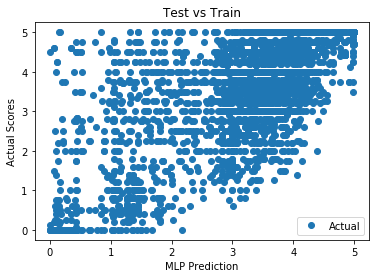

In [18]:
df = pd.DataFrame({'Predicted': test_prediction, 'Actual': testing_scores_y}) 
df['Actual-pred'] = df['Actual'].rsub(df['Predicted'])
df.describe()  
df.plot(x='Predicted', y='Actual', style='o')  
plt.title('Test vs Train')  
plt.xlabel('MLP Prediction')  
plt.ylabel('Actual Scores')  
plt.show()  

In [19]:
what_changed = "Removed Char length dif. Ner, pos edit disabled, lemmas disabled, lesk jaccard and cosine disabled"
df
print(df.describe().to_string())

         Predicted       Actual  Actual-pred
count  3108.000000  3108.000000  3108.000000
mean      3.154867     3.506064    -0.351197
std       1.204911     1.370625     1.027267
min       0.000000     0.000000    -4.856800
25%       2.755417     2.809000    -0.926683
50%       3.466100     3.800000    -0.290333
75%       3.923800     4.600000     0.265550
max       5.000000     5.000000     2.662867


In [20]:
#these will be logged to your sklearn-demos project on Comet.ml
params={"main experiment changes":what_changed,
        "statistics": df.describe().to_string(),
        "random_state":random_state,
        "MLP_iterations": itera,
        "MLP_solver":solv,
        "MLP_activation":activ,
        "SVM_gamma":gamma_type,
        "SVM_C":c_val,
        "SVM_epsilon":epsilon_val
        #"stratify":True
}

metrics = {'MLP Training Accuracy':a,
'MLP Testing Accuracy':b,
'MLP Drop Train-Test':a-b,
'MLP_mod Training Accuracy':c,
'MLP_mod Testing Accuracy':d,
'MLP_mod Drop Train-Test':c-d,
'SVM Training Accuracy':e,
'SVM Testing Accuracy':f,
'SVM Drop Train-Test':e-f,
'KNN Training Accuracy':g,
'KNN Testing Accuracy':h,
'KNN Drop Train-Test':g-h
}

experiment.log_dataset_hash(X_train_scaled)
experiment.log_parameters(params)
experiment.log_metrics(metrics)